In [122]:
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image
import augmentations
from augmentations import *

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

import dataloaders
from dataloaders import *

'''Dataloader'''
class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('images','masks')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)
        
        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'])
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)

        label = self.data_frame.iloc[idx]['category']       

        if self.transform:
            image,mask = self.transform(image,mask)
        
        mask_final = mask[0,:,:]
        mask_final[mask_final<0.5] = 0
        mask_final[mask_final>0.5] = 1
        
        return {'image':image, 'category':label, 'mask':mask_final, 'name':self.data_frame.iloc[idx]['name']}
    
def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': Compose([
            Resize(image_size),
            RandomHorizontallyFlip(0.5),
            #RandomVerticallyFlip(0.5),
            RandomTranslate((0.2,0.2)),
            RandomRotate(15),
            ToTensor(),
            Normalize(img_mean,img_std)
        ]),
        'valid': Compose([
            Resize(image_size),
            ToTensor(),
            Normalize(img_mean,img_std)
        ]),
        'test': Compose([
            Resize(image_size),
            ToTensor(),
            Normalize(img_mean,img_std)        
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        if x == 'train':
            bs = batch_size
            sh = True
        elif x == 'valid':
            bs = batch_size
            sh = False
        else:
            bs = 1
            sh = False
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,shuffle=sh, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device

#Selector network

#The selector output is 5x5x5. Each patch will have 5 anchor boxes

def build_selector():

    class mdl(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model 
            self.l1 = nn.Conv2d(512,5,3,stride=1)
        def forward(self, x):
            x = self.base(x)
            x = self.l1(x)   
            return x

    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])

    #r = models.resnet101(pretrained=True)
    #r1 = nn.Sequential(*list(r.children())[:-2])
    
    model = mdl(v1[-1])
        
    return model

## Predictor-Discriminator-Baseline
def build_baseline_predictor():

    class mdl(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model 
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc1 = nn.Linear(512,2)

        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            return x,x_base 

    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])

    #r = models.resnet101(pretrained=True)
    #r1 = nn.Sequential(*list(r.children())[:-2])
    
    model = mdl(v1[-1])
    model.load_state_dict(torch.load('./Weights/grad_cam_vgg_16_oxford.pt'))
        
    return model

def get_sample(target):

    prob_vector = F.softmax(target.view(-1))
    probs = prob_vector.data.cpu().numpy()
    
    probs = probs.astype('float64')
    probs = probs/probs.sum()
    
    try:
        prob_sample = np.random.multinomial(1,probs,1)
    except:import pdb;pdb.set_trace()
    return prob_sample.reshape(target.shape)

def get_anchor_box(m_r,m_c,img_shape,patch_shape):
    
    r1 = max(0,m_r - patch_shape[0]//2)
    r2 = min(img_shape[0],m_r + patch_shape[0]//2)
    
    c1 = max(0,m_c - patch_shape[1]//2)
    c2 = min(img_shape[1],m_c + patch_shape[1]//2)
    
    if r1 == 0:
        r2 = patch_shape[0]
        
    if r2 == img_shape[0]:
        r1 = img_shape[0]-patch_shape[0]
        
    if c1 == 0:
        c2 = patch_shape[1]
        
    if c2 == img_shape[1]:
        c1 = img_shape[1]-patch_shape[1]
        
    if r2-r1 != patch_shape[0] and c2-c1 != patch_shape[1]:
        import pdb;pdb.set_trace()
    
    return r1,r2,c1,c2

def get_patch_center(inp,img_shape,width_scale=1):
    
    grid = inp
    _,c,h,w = inp.shape
    _,c_l,h_l,w_l = np.where(grid==1)
    
    c_l = c_l[0]
    h_l = h_l[0]
    w_l = w_l[0]
    
    patch_h = img_shape[0]//h
    patch_w = img_shape[1]//(w*width_scale)
    
    patch_h_4 = patch_h//4
    patch_w_4 = patch_w//4
    
    r1 = h_l*patch_h
    r2 = (h_l+1)*patch_h
    
    c1 = c_l*patch_w
    c2 = (c_l+1)*patch_w
    
    m_r = (r1+r2)//2
    m_c = (c1+c2)//2
    
    if c_l == 1:
        m_r = m_r - patch_h_4
        m_c = m_c - patch_w_4
        
    elif c_l == 2:
        m_r = m_r - patch_h_4
        m_c = m_c + patch_w_4

    elif c_l == 3:
        m_r = m_r + patch_h_4
        m_c = m_c + patch_w_4

    elif c_l == 4:
        m_r = m_r + patch_h_4
        m_c = m_c - patch_w_4

    m_r = int(m_r)
    m_c = int(m_c)
    
    return m_r,m_c

def intersection_metric(anchor,mask):
    r1,r2,c1,c2 = anchor
    #return mask[0,r1:r2,c1:c2].sum()/((r2-r1)*(c2-c1))
    return mask[0,r1:r2,c1:c2].mean()
    
    
## DC-INVASE class
class dc_invase():
    def __init__(self,epochs,input_shape,patch_shape):
        
        #Initialization
        self.data_dir =  '../Data/oxford_pets/sparse_images/'
        self.train_csv = '../CSV/oxford_pet_train.csv'
        self.num_epochs = epochs
        self.input_shape = input_shape
        self.patch_shape = patch_shape
        self.batch_size = 1
        self.img_mean = [0.485, 0.456, 0.406]
        self.img_std = [0.229, 0.224, 0.225]
        
        self.exp_name = './Weights/weak_sup_ox_1'
        
        #Define the four models
        self.selector = build_selector()
        self.baseline = build_baseline_predictor()
        self.predictor = build_baseline_predictor()
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.baseline = self.baseline.cuda()
        self.predictor = self.predictor.cuda()
        
        '''baseline in evaluate mode'''
        self.baseline.eval()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6, amsgrad=False)
        self.optimizer_pred = optim.Adam(self.predictor.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6, amsgrad=False)

        
    def train(self):
        
        since = time.time()
        best_iou = 0
        best_acc = 0
        best_auc = 0
        best_col = 0
        best_row = 0
        best_agree = 0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':                
                    #Set the models to training mode
                    self.selector.train()
                    self.baseline.eval()
        
                else:
                    #Set the models to evaluation mode
                    self.selector.eval()
                    self.predictor.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_pred_loss = 0.0
              
                #Metrics : accuracy
                running_pred_acc = 0
                running_base_acc = 0
                running_int = 0
                running_agree = 0
                
                '''col and row list'''
                running_col = 0
                running_row = 0
                
                
                '''aucroc'''
                y_true = []
                y_pred = []
                
                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:
                    
                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    mask = sampled_batch['mask']
                    
                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)
                    mask = mask.to(self.device)
                    
                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_pred.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                        
                        #Generate predictor output probabilities
                        base_out,_ = self.baseline(inputs)
                        base_prob = F.softmax(base_out)
                        _, base_preds = torch.max(base_out, 1)
                        
                        #=>Baseline Cross entropy
                        base_ce_loss = F.cross_entropy(base_out,labels)
                                          
                        '''Generate selection probabilites using selector function'''
                        sel_prob = self.selector(inputs)
                           
                        '''Sample using selector output'''
                        probs_sample = get_sample(sel_prob)

                        m_r,m_c = get_patch_center(probs_sample,self.input_shape,1)

                        r1,r2,c1,c2 = get_anchor_box(m_r,m_c,self.input_shape,self.patch_shape)
                        
                        
                        '''Patch midpoint'''
                        running_col += (c1+c2)/2
                        running_row += (r1+r2)/2
                        
                        '''Intersection metric'''
                        int_met = intersection_metric([r1,r2,c1,c2],mask)
                        
                        '''Extract patch'''
                        patch = inputs[0,:,r1:r2,c1:c2].unsqueeze(dim=0)

                        '''Generate predictor output probabilities using the baseline cnn'''
                        pred_out,_ = self.predictor(patch)
                        pred_prob = F.softmax(pred_out)
                        _, pred_preds = torch.max(pred_out, 1)

                        '''predictor cross entropy'''
                        pred_ce_loss = F.cross_entropy(pred_out,labels)
                        
                        '''aucroc'''
                        y_true.append(labels.data)
                        y_pred.append(pred_prob.data[0][1])
                        
                        if base_preds == pred_preds:
                            running_agree += 1


                        with torch.no_grad():

                            k_l = pred_ce_loss - base_ce_loss                  

                        probs_sample = torch.Tensor(probs_sample).to(self.device)
                        
                        probs_sample = probs_sample.view(-1)
                        sel_prob = F.softmax(sel_prob.view(-1))
                        
                        distribution_loss = torch.sum(probs_sample*torch.log(sel_prob + 1e-8)) #+ (1-probs_sample)*torch.log(1 - sel_prob + 1e-8))
                                                
                        sel_loss = distribution_loss*(k_l)# + 10*abs((r1+r2)/2-self.input_shape[0]//2)/self.input_shape[0]
                                                                
                        '''Back propogation'''
                        if phase == 'train':
                            
                            '''update predictor'''
                            pred_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_pred.step()
                            
                            '''update selector'''
                            sel_loss.backward()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_sel.step()
                                    
                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_base_acc += torch.sum(base_preds == labels.data)
                    running_int += int_met * inputs.size(0)
                    
                    
                    pbar.update(inputs.shape[0])
                pbar.close()

                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                
                epoch_base_acc = running_base_acc.double()/ self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_int = running_int / self.dataset_sizes[phase]
                epoch_agree = running_agree / self.dataset_sizes[phase]
                
                epoch_auc_roc = sklearn.metrics.roc_auc_score(y_true,y_pred,average='weighted')
                epoch_row = running_row/self.dataset_sizes[phase]
                epoch_col = running_col/self.dataset_sizes[phase]
                
                print('{} Sel_Loss: {:.4f} Pred_Loss: {:.4f} BAC: {:.4f} PAC: {:.4f} Agree: {:.4f} Int: {:.4f} Auc: {:4f} Row: {:4f} Col: {:4f}'.format(
                    phase, epoch_sel_loss, epoch_pred_loss, epoch_base_acc, epoch_pred_acc, epoch_agree, epoch_int, epoch_auc_roc,epoch_row,epoch_col))

                print('Best auc: {:.4f} Best row: {:.4f} Best Col: {:.4f} Best Int: {:.4f} Best Agree: {:.4f}'.format(best_auc, best_row,
                                                       best_col, best_iou, best_agree))
                
                # deep copy the model
                if phase == 'valid' and epoch_auc_roc > best_auc:
                    
                    best_row = epoch_row
                    best_col = epoch_col
                    best_iou = epoch_int
                    best_agree = epoch_agree
                    best_auc = epoch_auc_roc
                    
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.predictor.state_dict(),self.exp_name+'_pred.pt')


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best iou: {:4f}'.format(best_iou))

        torch.save(self.baseline.state_dict(),self.exp_name+'_base_final.pt')
        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')

        print('Training completed finally !!!!!')
        
    def test(self):
                
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        
        self.predictor.load_state_dict(torch.load(self.exp_name+'_pred.pt'))
        self.predictor.eval()
        
        acc = 0
        total = 0
        iou = 0
        
        y_true = []
        y_pred = []
        
        patch_list = []
        image_list = []
        
        mode = 'test'
        
        with torch.no_grad():
            
            pbar = tqdm(total=self.dataset_sizes[mode])
            for data in self.dataloaders[mode]:

                inputs = data['image']
                labels = data['category']
                mask = data['mask']
                
                inputs = inputs.to(self.device)
                labels = labels.to(self.device) 
                
                '''Generate selection probabilites using selector function'''
                sel_prob = self.selector(inputs)

                '''Sample using selector output'''
                probs_sample = get_sample(sel_prob)

                m_r,m_c = get_patch_center(probs_sample,self.input_shape,1)

                r1,r2,c1,c2 = get_anchor_box(m_r,m_c,self.input_shape,self.patch_shape)

                assert r2-r1 == self.patch_shape[0]
                assert c2-c1 == self.patch_shape[1]
                
                '''Intersection metric'''
                int_met = intersection_metric([r1,r2,c1,c2],mask)

                '''Extract patch'''
                patch = inputs[0,:,r1:r2,c1:c2].unsqueeze(dim=0)

                '''Generate predictor output probabilities using the baseline cnn'''
                pred_out,_ = self.predictor(patch)
                pred_prob = F.softmax(pred_out)
                _, pred_preds = torch.max(pred_out, 1)

                '''aucroc'''
                y_true.append(labels.data)
                y_pred.append(pred_prob.data[0][1])

                if pred_preds == labels.data:
                    acc+=1
    
                iou += int_met
                
                base_path = '../Experiments/Oxford_pets/'
                name = data['name'][0]

                pr = name.replace('.j','_weak_sup.j')
                
                image_np = cv2.resize(cv2.imread('../Data/oxford_pets/sparse_images/'+name),(256,256))
                patch_np = image_np[r1:r2,c1:c2,:]
                cv2.imwrite(base_path+pr,patch_np)
                
                patch_list.append(patch_np)
                image_list.append(image_np)

                pbar.update(inputs.shape[0])
                
            pbar.close()
            
            acc /= self.dataset_sizes[mode]
            iou /= self.dataset_sizes[mode]
            auc = sklearn.metrics.roc_auc_score(y_true,y_pred,average='weighted')
            
            print('Acc: {:.4f} IoU: {:.4f} AUC: {:.4f}'.format(acc,iou,auc))                

            return patch_list,image_list
            
    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['valid']

In [123]:
dc = dc_invase(20,(256,256),(64,64))

In [115]:
p,i = dc.test()

Acc: 0.8420 IoU: 0.4859 AUC: 0.9224


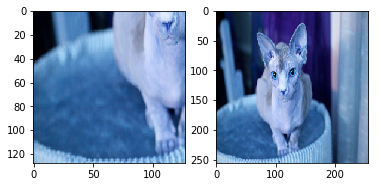

In [121]:
t = 5
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(p[t])
f.add_subplot(1,2, 2)
plt.imshow(i[t])
plt.show(block=True)

In [ ]:
dc.train()

Epoch 0/19
----------


train Sel_Loss: -0.7950 Pred_Loss: 0.6813 BAC: 0.9935 PAC: 0.5898 Agree: 0.5913 Int: 0.4482 Auc: 0.642645 Row: 105.193597 Col: 120.862431
Best auc: 0.0000 Best row: 0.0000 Best Col: 0.0000 Best Int: 0.0000 Best Agree: 0.0000


valid Sel_Loss: -90.9107 Pred_Loss: 18.8593 BAC: 0.9700 PAC: 0.6310 Agree: 0.6230 Int: 0.3904 Auc: 0.705868 Row: 121.619000 Col: 111.464000
Best auc: 0.0000 Best row: 0.0000 Best Col: 0.0000 Best Int: 0.0000 Best Agree: 0.0000
Epoch 1/19
----------


train Sel_Loss: -0.1327 Pred_Loss: 0.7728 BAC: 0.9925 PAC: 0.5103 Agree: 0.5118 Int: 0.3884 Auc: 0.501409 Row: 100.861431 Col: 117.430715
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230


valid Sel_Loss: -1.6820 Pred_Loss: 0.6942 BAC: 0.9700 PAC: 0.5000 Agree: 0.5120 Int: 0.3993 Auc: 0.627326 Row: 119.092000 Col: 102.929000
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230
Epoch 2/19
----------


train Sel_Loss: -0.1019 Pred_Loss: 0.6744 BAC: 0.9910 PAC: 0.5818 Agree: 0.5818 Int: 0.1672 Auc: 0.614433 Row: 115.015008 Col: 45.987994
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230


valid Sel_Loss: -1.9207 Pred_Loss: 0.6384 BAC: 0.9700 PAC: 0.6410 Agree: 0.6330 Int: 0.2938 Auc: 0.696312 Row: 123.581000 Col: 87.629000
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230
Epoch 3/19
----------


train Sel_Loss: -0.0595 Pred_Loss: 0.6452 BAC: 0.9925 PAC: 0.6333 Agree: 0.6308 Int: 0.1599 Auc: 0.658938 Row: 121.651826 Col: 42.344172
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230


valid Sel_Loss: -1.7272 Pred_Loss: 0.6617 BAC: 0.9700 PAC: 0.6290 Agree: 0.6150 Int: 0.2840 Auc: 0.686784 Row: 118.836000 Col: 77.617000
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230
Epoch 4/19
----------


train Sel_Loss: -0.0478 Pred_Loss: 0.6487 BAC: 0.9930 PAC: 0.6168 Agree: 0.6178 Int: 0.1627 Auc: 0.659908 Row: 107.300150 Col: 42.836918
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230


valid Sel_Loss: -1.5400 Pred_Loss: 0.6289 BAC: 0.9700 PAC: 0.6440 Agree: 0.6380 Int: 0.2983 Auc: 0.701444 Row: 121.437000 Col: 80.855000
Best auc: 0.7059 Best row: 121.6190 Best Col: 111.4640 Best Int: 0.3904 Best Agree: 0.6230
Epoch 5/19
----------


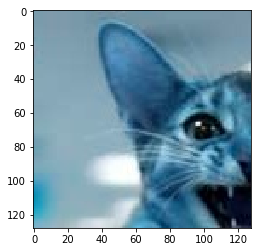

In [44]:
plt.imshow(cv2.imread('../Experiments/Oxford_pets/cat_Abyssinian_'))

In [ ]:
%d

In [ ]:
%d

In [ ]:
plt.imshow(cv2.imread('../Experiments/Oxford_pets/cat_Abyssinian_105_bin_8x8_samp_share_1_final.jpg'))

In [ ]:
dc.train()

In [ ]:
!nvidia-smi